In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision import transforms
import sys
import torch
from torch.utils.data import DataLoader

sys.path.append("../")
from datasets.FreiHAND import FreiHAND, FreiHAND_evaluation
from models.models import CustomHeatmapsModel
from utils.testing import batch_epe_calculation,batch_auc_calculation,batch_pck_calculation, show_batch_predictions
from utils.utils import heatmaps_to_coordinates
from config import *

### Config data

In [2]:
config = {
    "data_dir": "/data/wmucha/datasets/FreiHAND",
    "model_path": "/caa/Homes01/wmucha/repos/applied_deep_learning/applied_dl/saved_models/fulldata_SGDmoment_classicval_126",
    "test_batch_size": TESTING_BATCH_SIZE,
    "device": TESTING_DEVICE
}

## Test subset of data

In [3]:
val_img_transform = val_image_transform = transforms.Compose(
                [
                    transforms.Resize(MODEL_IMG_SIZE),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=TRAIN_DATASET_MEANS, std=TRAIN_DATASET_STDS)
                ]
            )

test_dataset = FreiHAND(config=config, set_type="test", img_transform=val_img_transform)
final_evaluation = FreiHAND_evaluation(config, img_transform= val_img_transform)


test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

final_evaluation_dataloader = DataLoader(
    final_evaluation,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)



Number of test samples: 6512


## Model

In [4]:
model = CustomHeatmapsModel(3, 21)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device(config["device"]))
)
model.eval()
print("Model loaded")


/caa/Homes01/wmucha/venvs/hands_keypoints/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded


## Evaluate on Test Data

In [5]:
def evaluate(model, dataloader, using_heatmaps = True, batch_size = 0):
    accuracy_all = []
    image_id = []
    pred = []
    gt = []
    pck_acc = []
    epe_lst = []
    auc_lst = []
   
    for data in tqdm(dataloader):
        inputs = data["image"]
        pred_heatmaps = model(inputs)
        pred_heatmaps = pred_heatmaps.detach().numpy()
        true_keypoints = (data["keypoints"]).numpy()

        if using_heatmaps == True:
            pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)
        else:
            pred_keypoints = pred_heatmaps.reshape(batch_size,N_KEYPOINTS,2)

        accuracy_keypoint = ((true_keypoints - pred_keypoints) ** 2).sum(axis=2) ** (1 / 2)
        accuracy_image = accuracy_keypoint.mean(axis=1)
        accuracy_all.extend(list(accuracy_image))

        # Calculate PCK@02
        avg_acc = batch_pck_calculation(pred_keypoints, true_keypoints, treshold = 0.2, mask = None, normalize = None)
        pck_acc.append(avg_acc)

        # Calculate EPE mean and median, mind that it depends on what scale of input keypoints 
        epe = batch_epe_calculation(pred_keypoints, true_keypoints)
        epe_lst.append(epe)

        # AUC calculation
        auc = batch_auc_calculation(pred_keypoints, true_keypoints, num_step=20, mask = None)
        auc_lst.append(auc)

    pck = sum(pck_acc) / len(pck_acc)
    epe_final = sum(epe_lst) / len(epe_lst)
    auc_final = sum(auc_lst) / len(auc_lst)

    print (f'PCK@2: {pck}, EPE: {epe_final}, AUC: {auc_final}')
    return accuracy_all, pck

In [6]:
accuracy_all, pck = evaluate(model,test_dataloader)

100%|██████████| 407/407 [06:07<00:00,  1.11it/s]

PCK@2: 0.9963729963729966, EPE: 1.943389395600777, AUC: 0.924675324675326


In [7]:
error = np.mean(accuracy_all)
print("Average error per keypoint: {:.1f}% from image size".format(error * 100))

for img_size in [RAW_IMG_SIZE, MODEL_IMG_SIZE]:
    error_pixels = error * img_size
    image_size = f"{img_size}x{img_size}"
    print(
        "Average error per keypoint: {:.0f} pixels for image {}".format(
            error_pixels, image_size
        )
    )

Average error per keypoint: 1.5% from image size
Average error per keypoint: 3 pixels for image 224x224
Average error per keypoint: 2 pixels for image 128x128


## Inference on Test Data

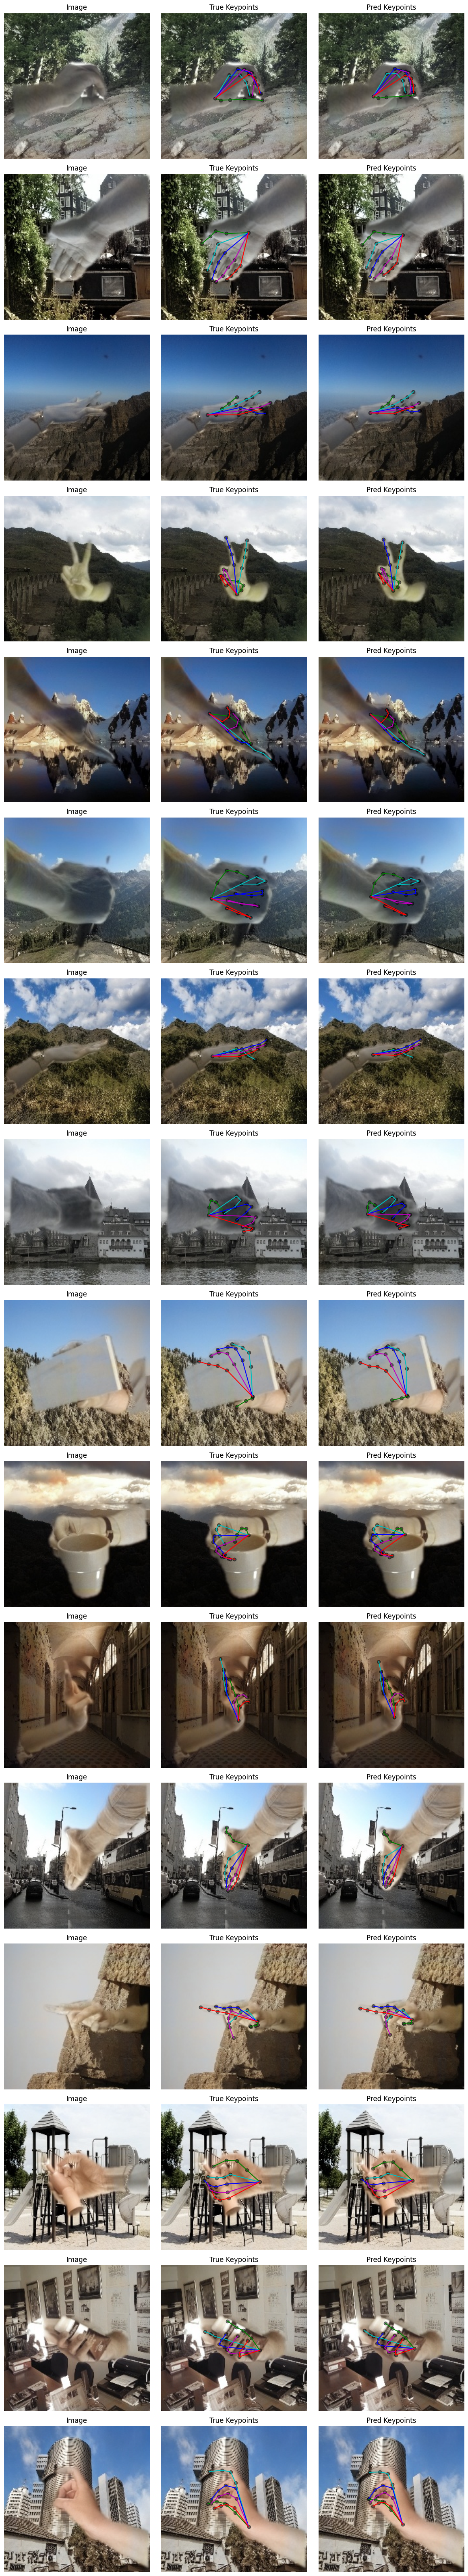

In [8]:
for data in test_dataloader:
    show_batch_predictions(data, model)
    break

## Evaluation on final evaluation dataset

In [9]:
accuracy_all, pck = evaluate(model,final_evaluation_dataloader)

100%|██████████| 248/248 [06:04<00:00,  1.47s/it]

PCK@2: 0.7803379416282644, EPE: 5.800852554001928, AUC: 0.8223406298003072


In [10]:
error = np.mean(accuracy_all)
print("Average error per keypoint: {:.1f}% from image size".format(error * 100))

for img_size in [RAW_IMG_SIZE, MODEL_IMG_SIZE]:
# for img_size in [1, RAW_IMG_SIZE/MODEL_IMG_SIZE]:
    error_pixels = error * img_size
    image_size = f"{img_size}x{img_size}"
    print(
        "Average error per keypoint: {:.0f} pixels for image {}".format(
            error_pixels, image_size
        )
    )

Average error per keypoint: 4.6% from image size
Average error per keypoint: 10 pixels for image 224x224
Average error per keypoint: 6 pixels for image 128x128


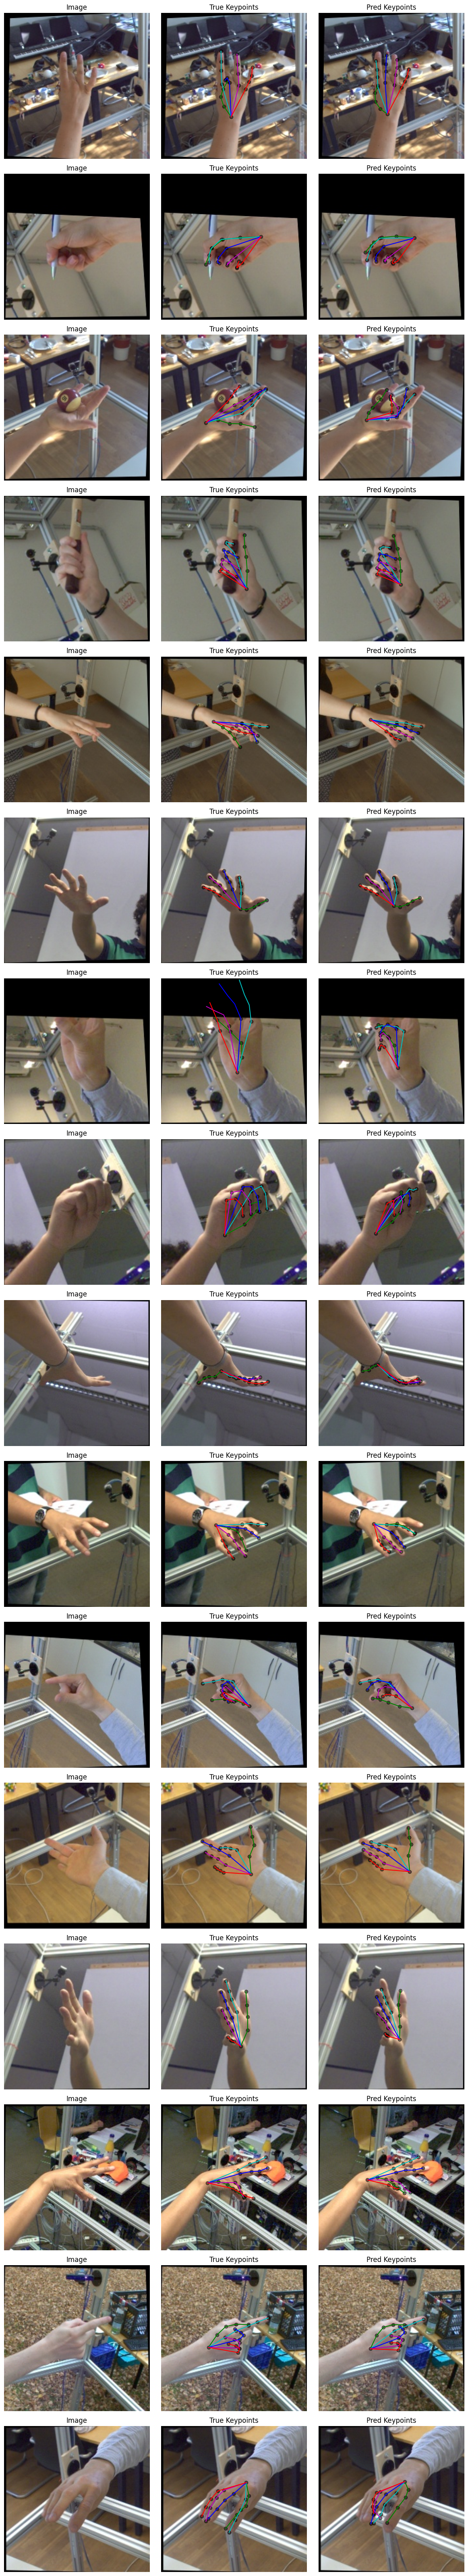

In [11]:
for data in final_evaluation_dataloader:
    show_batch_predictions(data, model)
    break